http://scikit-learn.org/stable/modules/svm.html

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

### IQFeed source

In [2]:
path = '/home/octo/Dropbox/IQ_data/'
spy=pd.read_csv(path + 'SPY.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
spxs= pd.read_csv(path + 'SPXS.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
spxl=pd.read_csv(path + 'SPXL.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
spy=spy.tail(140000)
spxs=spxs.tail(140000)
spxl=spxl.tail(140000)

### Google Source

https://github.com/parthasen/ALGO/blob/MIX/google_data

### DS IQfeed

### ratio of price and volume will show sentiment

In [3]:
df_ratio = pd.DataFrame(data=spxs.close)
df_ratio['spxs'] = pd.DataFrame(data=spxs.close)
df_ratio['spxl']= pd.DataFrame(data=spxl.close)
df_ratio['spxs_v'] = pd.DataFrame(data=spxs.volume)
df_ratio['spxl_v']= pd.DataFrame(data=spxl.volume)
df_ratio=df_ratio.dropna()
df_ratio['ratio']=df_ratio.spxl/df_ratio.spxs
df_ratio['ratio_v']=df_ratio.spxl_v/df_ratio.spxs_v
df_ratio['mean'] = pd.rolling_mean(df_ratio.ratio,60)
df_ratio['mean_v'] = pd.rolling_mean(df_ratio.ratio_v,60)
df_ratio=df_ratio.dropna()
#df_ratio.tail()

In [4]:
#df_ratio['mean'].head()

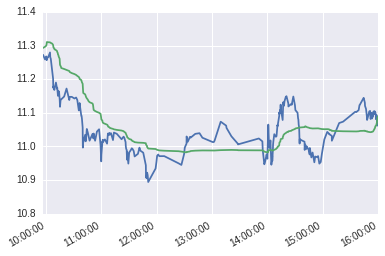

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
%matplotlib inline
df_ratio['ratio'].tail(300).plot()
df_ratio['mean'].tail(300).plot()
plt.show()

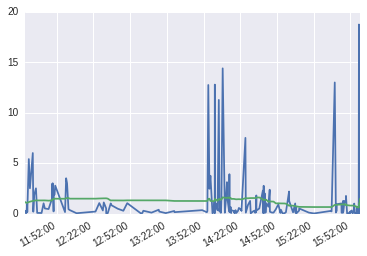

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
%matplotlib inline
df_ratio['ratio_v'].tail(200).plot()
df_ratio['mean_v'].tail(200).plot()
plt.show()

In [7]:
#df_ratio.tail()

In [8]:
# Last day price. This will help to decide next price Jumed UP or Down!
spy['2017-01-31 16:00:00']

,high,low,open,close,total_volume,volume
2017-01-31 16:00:00,227.6,227.46,227.47,227.56,63272312,818707


In [117]:
#Base point. Starting point to fix UL,LL
spy['2017-02-01 09:40:00']['close']

2017-02-01 09:40:00    228.46
Name: close, dtype: float64

In [318]:
spy['p60']=pd.DataFrame(data=spy.close.shift(-60))
spy=spy.dropna()

In [319]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

In [324]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(pd.DataFrame(spy.p60),pd.DataFrame(spy.open))
pr=regr.predict(pd.DataFrame(spy.p60))

In [341]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ 0.9955897]]))


In [342]:
# The coefficients
print('Coefficients: \n', regr.intercept_)

('Coefficients: \n', array([ 0.99813662]))


In [358]:
# data set only above the threshold speed of 0.1
data_np=pd.DataFrame(data=spy.open)
data_np['close']=pd.DataFrame(data=spy.close)
data_np['pr']=pr
data_np['err']=data_np.pr-spy.open
data_np['ch']=pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(-12))),5)
#data_np['ch-pr']=pd.rolling_sum(pd.DataFrame(data=(data_np.pr-spy.close.shift(-12))),5)
data_np['vol_ud']=np.where(pd.DataFrame(data=spy.volume>pd.rolling_mean(spy.volume,60)),1,np.where(pd.DataFrame(data=spy.volume<pd.rolling_mean(spy.volume,60)),-1,0))
#data_np['vol_d']=np.where(pd.DataFrame(data=spy.volume<pd.rolling_mean(spy.volume,60)),-1,0)
data_np['ret_np'] = np.where(pd.DataFrame(data=(spy.open/spy.close.shift(-12))-1)>0.0003,1,np.where(pd.DataFrame(data=(spy.open/spy.close.shift(-12))-1)<-0.0003,-1,0))
#data_np['ret_n'] = np.where(pd.DataFrame(data=(spy.open/spy.close.shift(-12))-1)<-0.0001,-1,0)
data_np['Volatility']=data_np['close'].apply(lambda x: np.log(x))/pd.rolling_std(data_np['close'],40)
data_np['momentum'] = talib.MOM(np.asarray(data_np['close']), timeperiod=40)
data_np['RSI'] =talib.RSI(np.asarray(data_np['close']), timeperiod=40)
data_np['3D']=np.logical_and(np.logical_and(spy.open.shift(-2)<spy.close.shift(-3),spy.open.shift(-1)<spy.close.shift(-2)),spy.open< spy.close.shift(-1))
data_np['3U']=np.logical_and(np.logical_and(spy.open.shift(-2)>spy.close.shift(-3),spy.open.shift(-1)>spy.close.shift(-2)),spy.open> spy.close.shift(-1))
data_np['ch0.12']=np.where(data_np.ch>0.12,1,np.where(data_np.ch<-0.12,-1,0))
data_np['ch0.25u']=np.where(data_np.ch>0.25,1,0)
data_np['ch0.25d']=np.where(data_np.ch<-0.25,-1,0)
data_np['1m'] = pd.rolling_mean(spy.close, 12)
data_np['5m'] = pd.rolling_mean(spy.close,60)
data_np['Cross']=np.where(data_np['1m']>data_np['5m'], 1,np.where(data_np['1m']<data_np['5m'],-1,0))
data_np['Cross_p']=np.where(np.logical_and(data_np['Cross']==1,data_np['Cross'].shift(-1)==0),1,np.where(np.logical_and(data_np['Cross']==-1,data_np['Cross'].shift(-1)==0),-1,0))
#data_np['ch0.3']=np.where(data_np.ch>0.3,1,np.where(data_np.ch<-0.3,-1,0))
#data_np['ch0.55']=np.where(data_np.ch>0.55,1,np.where(data_np.ch<-0.55,-1,0))
data_np=data_np[data_np['ch0.12']!=0]
data_np=data_np[data_np['vol_ud']!=0]
#data_np=data_np[data_np['ret_np']!=0]
#data_p=data_p.drop(data_p[0],axis=1).dropna()
data_np=data_np.dropna()

In [359]:
data_np.tail()

,open,close,pr,err,ch,vol_ud,ret_np,Volatility,momentum,RSI,3D,3U,ch0.12,ch0.25u,ch0.25d,1m,5m,Cross,Cross_p
2017-02-01 15:51:35,227.680,227.6800,227.693813,0.013813,0.4165,1,0,156.426014,0.0500,45.168758,False,False,1,1,0,227.710817,227.686708,1,0
2017-02-01 15:51:40,227.690,227.6400,227.693912,0.003912,0.3915,1,0,159.587801,0.0191,40.227900,False,False,1,1,0,227.704150,227.684803,1,0
2017-02-01 15:51:45,227.650,227.6400,227.693912,0.043912,0.3165,1,0,163.190073,0.0200,40.227900,False,False,1,1,0,227.697483,227.683137,1,0
2017-02-01 15:51:50,227.640,227.6511,227.688934,0.048934,0.2250,1,0,166.393548,0.0210,42.077448,False,False,1,0,0,227.692575,227.681988,1,0
2017-02-01 15:51:55,227.655,227.6450,227.659066,0.004066,0.1650,-1,0,167.151272,0.0050,41.356159,False,True,1,0,0,227.686550,227.680572,1,0


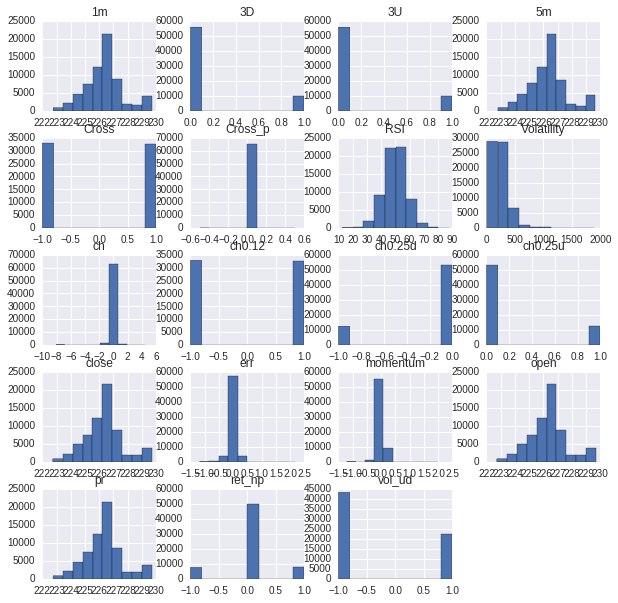

In [360]:
pd.DataFrame.hist(data_np, figsize = [10,10]);

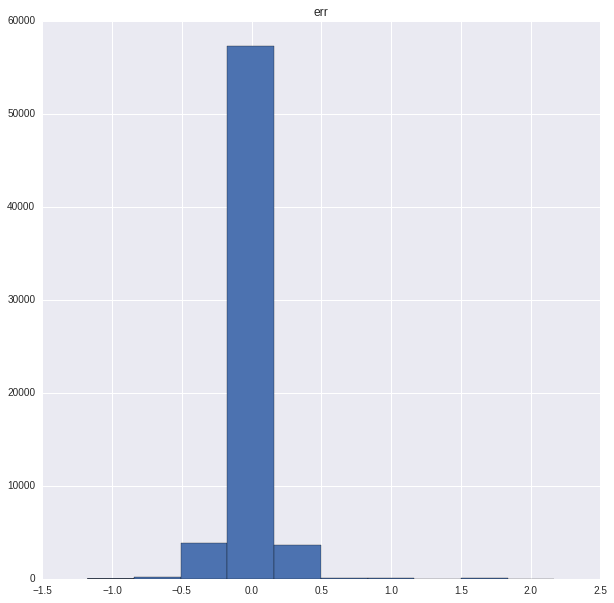

In [363]:
pd.DataFrame.hist(data_np[['err']], figsize = [10,10]);
#pd.DataFrame.hist(data_np[['ch0.55']], figsize = [10,10]); very less

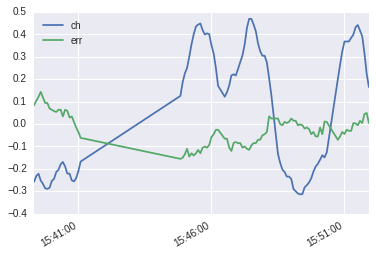

In [369]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
%matplotlib inline
data_np[['ch','err']].tail(100).plot()
plt.show()

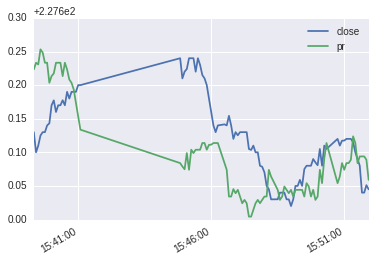

In [368]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
%matplotlib inline
data_np[['close','pr']].tail(100).plot()
plt.show()

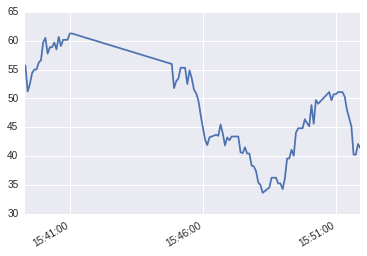

In [370]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
%matplotlib inline
data_np['RSI'].tail(100).plot()
plt.show()

### SVM using Iqfeed data

In [10]:
#df_svm['sum_spy'] = pd.rolling_sum(df_svm.ret_spy,1)
#df_svm['mean_spy'] = pd.rolling_mean(df_svm.sum_spy,180)
#df=df.drop('c',axis=1).dropna()

##### finding jump
##### change in 3 min of 0.25 is jump 

In [11]:
#https://mrjbq7.github.io/ta-lib/func.html
#https://github.com/parthasen/ALGO/blob/MIX/TA.py
#TA.py for self made technical analysis 
import talib

In [184]:
#https://github.com/parthasen/ALGO/blob/MIX/ML_classification_NB.ipynb

"""df_svm=pd.DataFrame(data=spy.close)
df_svm['ju'] = np.where(pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(-12))),15)>0.10,1,0)
df_svm['ju'] = np.where(df_svm['ju'].shift(-1)==df_svm['ju'],0,1)
df_svm['jd'] = np.where(pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(-1))),15)<-0.10,-1,0)
df_svm['jd'] = np.where(df_svm['jd'].shift(-1)==df_svm['jd'],0,1)
df_svm['volume_u']=np.where(pd.DataFrame(data=spy.volume>pd.rolling_mean(spy.volume,180)),1,0)
df_svm['volume_d']=np.where(pd.DataFrame(data=spy.volume<pd.rolling_mean(spy.volume,180)),-1,0)
df_svm['ret_p'] = np.where(pd.DataFrame(data=(spy.open/spy.close.shift(-1))-1)>0.0001,1,0)
df_svm['ret_n'] = np.where(pd.DataFrame(data=(spy.open/spy.close.shift(-1))-1)<-0.0001,-1,0)
df_svm['Volatility']=df_svm['close'].apply(lambda x: np.log(x))/pd.rolling_std(df_svm['close'],40)
df_svm['momentum'] = talib.MOM(np.asarray(df_svm['close']), timeperiod=40)
df_svm['RSI'] =talib.RSI(np.asarray(df_svm['close']), timeperiod=40)
df_svm=df_svm.dropna()"""

"df_svm=pd.DataFrame(data=spy.close)\ndf_svm['ju'] = np.where(pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(-12))),15)>0.10,1,0)\ndf_svm['ju'] = np.where(df_svm['ju'].shift(-1)==df_svm['ju'],0,1)\ndf_svm['jd'] = np.where(pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(-1))),15)<-0.10,-1,0)\ndf_svm['jd'] = np.where(df_svm['jd'].shift(-1)==df_svm['jd'],0,1)\ndf_svm['volume_u']=np.where(pd.DataFrame(data=spy.volume>pd.rolling_mean(spy.volume,180)),1,0)\ndf_svm['volume_d']=np.where(pd.DataFrame(data=spy.volume<pd.rolling_mean(spy.volume,180)),-1,0)\ndf_svm['ret_p'] = np.where(pd.DataFrame(data=(spy.open/spy.close.shift(-1))-1)>0.0001,1,0)\ndf_svm['ret_n'] = np.where(pd.DataFrame(data=(spy.open/spy.close.shift(-1))-1)<-0.0001,-1,0)\ndf_svm['Volatility']=df_svm['close'].apply(lambda x: np.log(x))/pd.rolling_std(df_svm['close'],40)\ndf_svm['momentum'] = talib.MOM(np.asarray(df_svm['close']), timeperiod=40)\ndf_svm['RSI'] =talib.RSI(np.asarray(df_svm['close']), timeperi

In [147]:
#df_svm.tail()

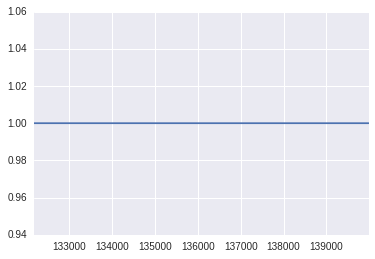

In [177]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
%matplotlib inline
data_p['ch'].tail(3000).plot()
plt.show()

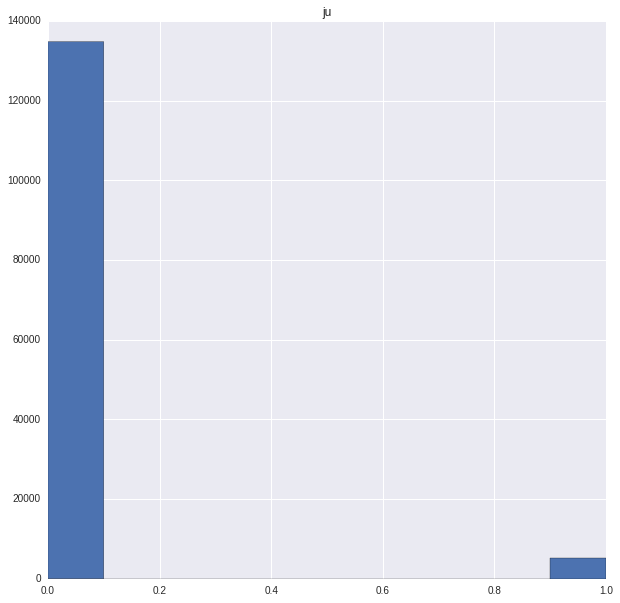

In [149]:
pd.DataFrame.hist(df_svm[['ju']], figsize = [10,10]);

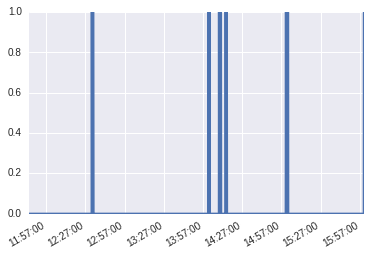

In [137]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
%matplotlib inline
df_svm['jd'].tail(3000).plot()
plt.show()

In [16]:
#pd.DataFrame.hist(df_svm, figsize = [15,15]);

In [52]:
#X=pd.DataFrame(df_svm[['volume_u','volume_d','ret_p','ret_n','Volatility','momentum','RSI']])
X=pd.DataFrame(df_svm[['volume_d','ret_n','Volatility','momentum','RSI']])
y=pd.DataFrame(df_svm[['jd']])

In [53]:
X=pd.DataFrame(X.tail(5000))
y=pd.DataFrame(y.tail(5000))

In [54]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Support Vector Machine
#### SVC

In [55]:
from sklearn import svm
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm_model_1 = svm.fit(X_train, y_train)
print('SVC accuracy for test set: %f' % svm_model_1.score(X_test, y_test))

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC accuracy for test set: 0.863000


In [56]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,svm_model_1.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00       137
          0       0.86      1.00      0.93       863

avg / total       0.74      0.86      0.80      1000



In [65]:
#np.where(pd.DataFrame(y_pred)==0)
pd.DataFrame(y_pred).tail(3)

,0
997,0
998,0
999,0


In [66]:
from sklearn import linear_model
lm = linear_model.LogisticRegression(C=1e4)
lm_model= lm.fit(X_train, y_train)
print('Logistic Regression accuracy for test set: %f' % lm_model.score(X_test, y_test))

Logistic Regression accuracy for test set: 0.863000


/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [102]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,lm_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.50      0.07      0.13       137
          0       0.87      0.99      0.93       863

avg / total       0.82      0.86      0.82      1000



In [98]:
#np.where(pd.DataFrame(y_pred)==0)
#pd.DataFrame(y_pred)

In [99]:
#pd.DataFrame(y_true)

In [108]:
#lm_model.predict(X_test)

In [106]:
X1=df_svm[['volume_d','ret_n','Volatility','momentum','RSI']].tail(3)
lm_model.predict(X1)

array([0, 0, 0])

In [ ]:
clf = svm.SVR()

In [ ]:
clf.fit(X, y)

In [287]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# Load the diabetes dataset

In [288]:
diabetes = datasets.load_diabetes()

In [297]:
# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

In [302]:
#pd.DataFrame(diabetes.data).tail(3)
#pd.DataFrame(diabetes_X).tail(3)

In [299]:
# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

In [303]:
#pd.DataFrame(diabetes_y_train).tail(3)